## Введение

Описание проекта
Контекст
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

## Шаг Первый: загрузка данных и подготовка к анализу

- Для начала загрузим нужные нам библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy import stats as st
import scipy.stats as stats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

- Загрузим датасеты:

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
visitors = pd.read_csv('/datasets/visitors.csv')
orders = pd.read_csv('/datasets/orders.csv')

### Таблица с гипотезами

In [3]:
hypothesis.head(5)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


### Таблица с визитами

In [5]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [6]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Измени тип данных date

In [7]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

### Таблица с заказами

In [8]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Изменим названия столбцов, подогнав их к написанным скриптам:

In [11]:
orders.rename(columns = {'visitorId':'userId', 'transactionId':'orderId'}, inplace = True)

Проверим, есть ли в группах пользователи, которые попали сразу в две группы:

In [12]:
duplicated_users = orders.groupby('userId').agg({'group':['nunique', 'unique']})
duplicated_users.columns = ['groups', 'group_name']
duplicated_users = duplicated_users.query('groups > 1')
duplicated_users.head()
print('Количество пересекающихся пользователей = {}'.format(len(duplicated_users)))

Количество пересекающихся пользователей = 58


В таком случае не лишним будет и проверить разницу в количестве пользователей: 

In [13]:
orders.groupby('group').agg({'userId':['nunique']})

,userId
,nunique
group,
A,503
B,586


Группа B имеет на 83 пользоваетеля больше - ошибка автоматизации

Пересекающиеся пользователи действительно есть. Такая погрешность это свидетельство ошибки автоматизации при проведении A/B-теста. Нужно отправить разработчикам отчет по данным.

In [14]:
orders = orders.query('userId not in @duplicated_users.index')
orders.head()

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


Проверим сколько осталось пользователей в группах после очистки:

In [15]:
orders.groupby('group').agg({'userId':['nunique']})

,userId
,nunique
group,
A,445
B,528


Группы все также различаются на 83 человека

### Вывод о данных

- Нужно привести данные с датами к типу date. 
- Данные не имеют пропусков.
- Группы имеют пересекающихся пользователей.
- Группы не равны.

## Шаг 2: Приоретизация гипотез

### Приоретизация гипотез по фреймворку ICE

In [16]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [17]:
hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


- По фреймворку ICE лидирует 8, 0 и 7 гипотезы

### Приоретизация гипотез по фреймворку RICE

In [18]:
hypothesis['RICE'] = hypothesis['Impact'] * hypothesis['Reach'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [19]:
hypothesis[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


- По фреймворку RICE лидируют 7, 2 и 0 гипотезы

### Выводы по приоретизации гипотез

Взглянем на получивщуюся таблицу

In [20]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


- При применении фреймворка RICE 8 гипотеза сдвинулась с первого места в середину, по сравнению с ICE. Так случилось из-за того, что параметр Reach (отвечающий за охват) для гипотезы 8 имеет 1. Тоже самое случилось и со второй гипотезой, однако здесь редуцирующим параметром стал параметр Impact.
- Рекомендации по гипотезам: советую проверить гипотезы 7 и 0, которые оказались в тройке лидеров по обоим фреймворкам.

## Анализ A/B-теста

### График кумулятивной выручки по группам

In [21]:
datesGroups = orders[['date','group']].drop_duplicates() 

In [22]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 'userId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [23]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [24]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 'userId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


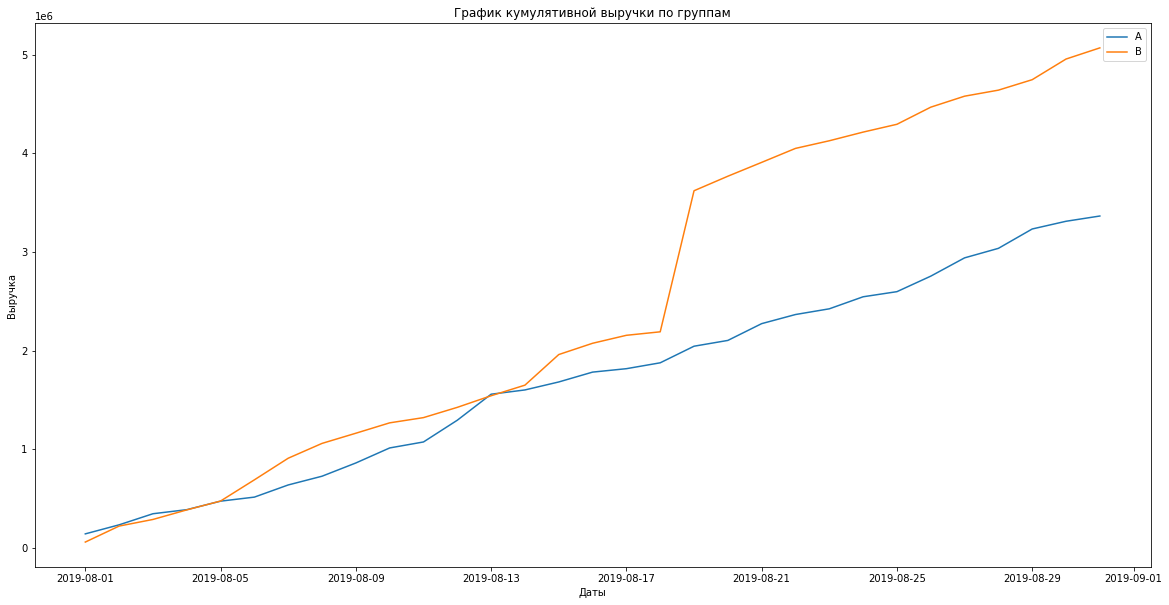

In [25]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.gcf().set_size_inches(20, 10)
plt.title('График кумулятивной выручки по группам')
plt.ylabel('Выручка')
plt.xlabel('Даты')
plt.show()

**Вывод кумулятивной выручки по группам:**
- Выручка уверенно увеличивается в течении всего теста
- График выручку в группе B имеет резкие скачки, возможно это выбросы
- Группа A уверенно проигрывает группе B

### График кумулятивного среднего чека по группам

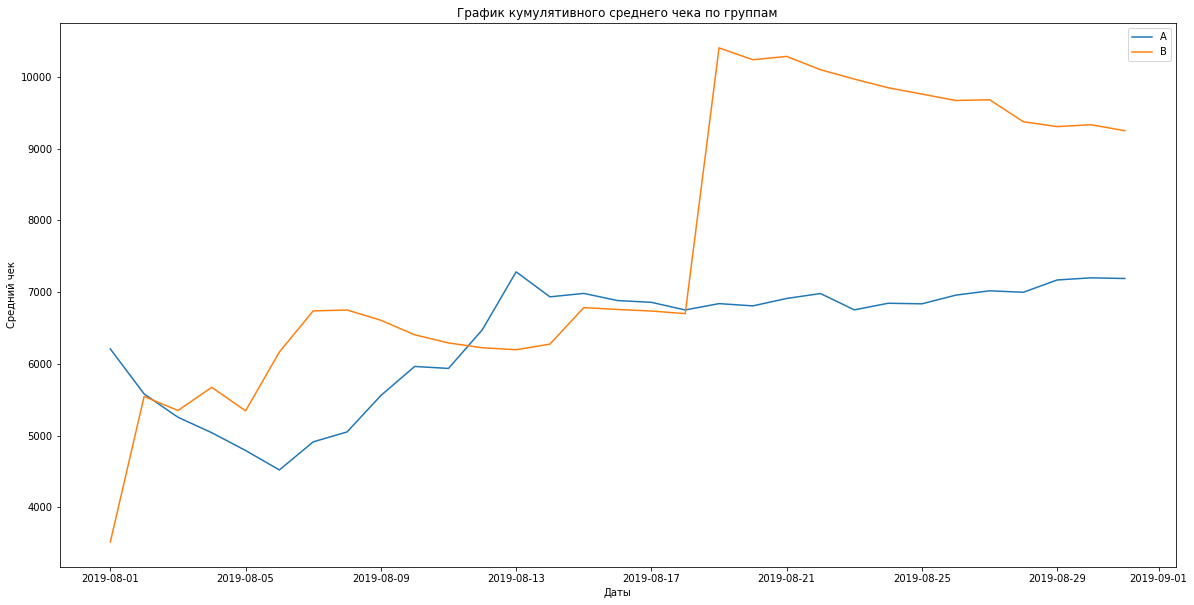

In [26]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.gcf().set_size_inches(20, 10)
plt.legend() 
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Средний чек')
plt.xlabel('Даты')
plt.show()

**Вывод по графику кумулятотивного среднего по группам:**
- Группа A имеет падение по среднему чеку в начале теста, однако стабилизируется к середине теста
- Группа В плавно растет по в начале теста и имеет резские всплеск в середине теста, который постепенно, медленно спадает

### График относительного изменения кумулятивного среднего чека группы B к группе A.

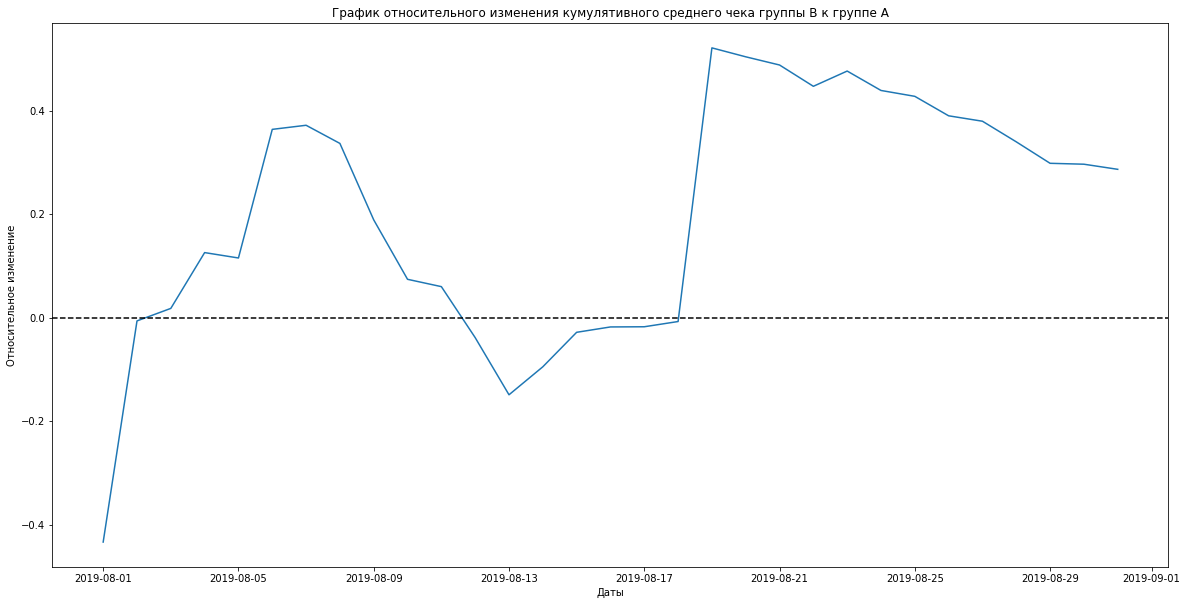

In [27]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.gcf().set_size_inches(20, 10)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel('Относительное изменение')
plt.xlabel('Даты')
plt.show()

**Выводы по графику относительного изменения кумулятивного среднего чека группы B к группе A:**
- На протяжении всего графика наблюдается резкие скачки между сегментами, скорее всего дело в выбросах

### График кумулятивной конверсии по группам

In [28]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

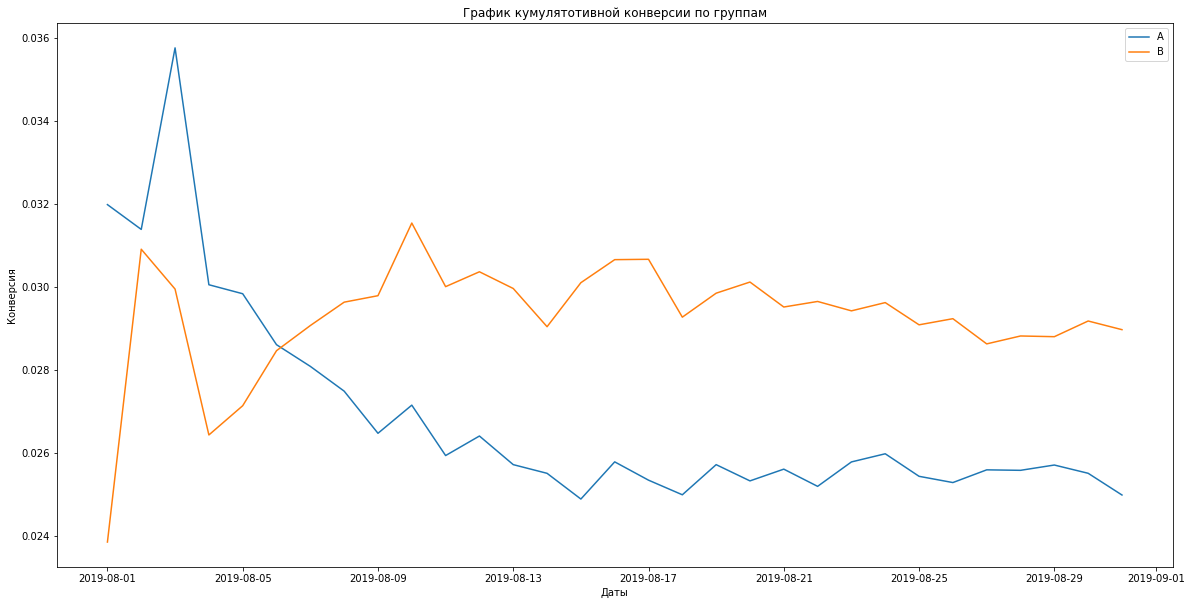

In [29]:
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.gcf().set_size_inches(20, 10)
plt.title('График кумулятотивной конверсии по группам')
plt.ylabel('Конверсия')
plt.xlabel('Даты')
plt.show()

**Выводы по графику кумулятотивной конверсии по группам:**
- Конверсия группы А стабилизировалась и находится ниже конверсии группы А
- В конверсии группы есть аномальный скачок в начале эксперимента, который сошел вниз по графику
- В группе В в начале эксперимента произошел резкий скачок и было его удержание.
- Конверсия группы В стабилизировалась

### График относительного изменения кумулятивной конверсии группы B к группе A

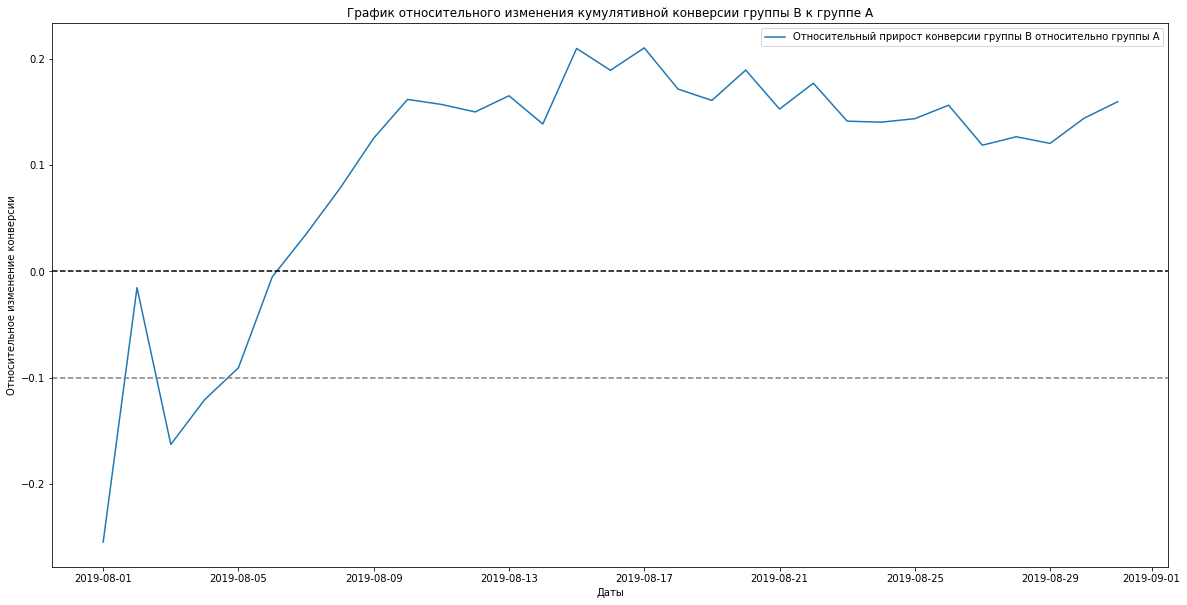

In [30]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.gcf().set_size_inches(20, 10)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.ylabel('Относительное изменение конверсии')
plt.xlabel('Даты')
plt.show()

**Выводы по графику относительного изменения кумулятивной конверсии группы B к группе A:**
- В начале теста группа В проигрывала группе А, но почти сразу же конверсия выросла и продолжает доминировать

### Точечный график количества заказов по пользователям

In [31]:
ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


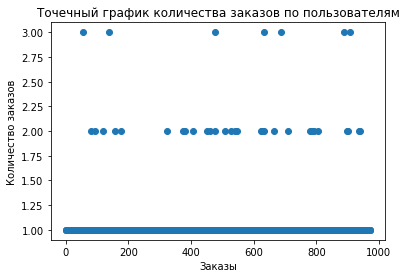

In [32]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Количество заказов')
plt.xlabel('Заказы')
plt.show()

**Вывод по точечному графику количества заказов по пользователям:**
- Аномальные значения не редки для данного графика, они начинаются уже 3 заказов

### 95-й и 99-й перцентили количества заказов на пользователя

In [33]:
ordersByUsersPercentile = np.percentile(ordersByUsers['orders'], [90, 95, 99])
print('90-ый перцентиль = {:.2f}'.format(ordersByUsersPercentile[0]))
print('95-ый перцентиль = {:.2f}'.format(ordersByUsersPercentile[1]))
print('99-ый перцентиль = {:.2f}'.format(ordersByUsersPercentile[2]))

90-ый перцентиль = 1.00
95-ый перцентиль = 1.00
99-ый перцентиль = 2.00


**Выводы по 95-ому и 99-ому перцентилям количества заказов на пользователя:**
- Слудует выбрать границу по количествам аномальных заказов на пользователя с 2 заказов

###  Точечный график стоимости заказов

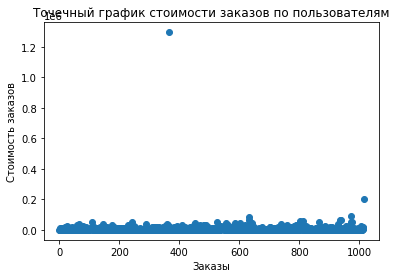

In [34]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимости заказов по пользователям')
plt.ylabel('Стоимость заказов')
plt.xlabel('Заказы')
plt.show()

**Вывод по точечному графику стомости заказов:**
- Аномальные заказы крайне редки, они располагаются лишь на границе 20 000 и 130 000.
- В основном все заказы лежат между 0 и 15 000

### 95-й и 99-й перцентили стоимости заказов

In [35]:
revenue_percentiles = np.percentile(orders['revenue'], [90, 95, 99])
print('90-ый перцентиль = {:.2f}'.format(revenue_percentiles[0]))
print('95-ый перцентиль = {:.2f}'.format(revenue_percentiles[1]))
print('99-ый перцентиль = {:.2f}'.format(revenue_percentiles[2]))

90-ый перцентиль = 17990.00
95-ый перцентиль = 26785.00
99-ый перцентиль = 53904.00


**Выводы по 95-ому и 99-ому перцентилям стомости заказов:**
- Следует выбрать границу для аномальных пользователей, которые выбрали заказ на больше, чем 34 000.

### Проверим данные на нормальность распределения 

Проверим как распределена выручка в группе А:

In [36]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(orders.query('group == "A"')['revenue'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  2.8240222045454137e-31
Отвергаем нулевую гипотезу: распределение не нормально


Проверим как распределена выручка в группе В:

In [37]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(orders.query('group == "B"')['revenue'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  4.203895392974451e-45
Отвергаем нулевую гипотезу: распределение не нормально


### Статистическая значимость различий в конверсии между группами по «сырым» данным

Построим таблицу для нахождения практической значимости:

In [38]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [39]:
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [40]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

In [41]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

H0 - разницы в конверсии между группами нет

H1 - разница в конверсии между группами есть

In [42]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, True, alternative="two-sided")[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.011
0.160


**Выводы по статистической значимости различий в конверсии между группами по «сырым» данным:**
- P-Value значительно ниже уровня статистической значимости в 0.05, что указывает на то, что между данными есть разница
- Нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем
- Относительный проигрыш группы B равен 16%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

H0 - Различие по среднему чеку между группами А и В нет

H1 - Различие по среднему чеку между группами А и В есть

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [43]:
print('P-Value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], True, alternative="two-sided")[1]))
print('Относительное различие группы В по сравнению с группой А = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-Value = 0.829
Относительное различие группы В по сравнению с группой А = 0.287


**Выводы по статистической значимость различий в среднем чеке заказа между группами по «сырым» данным:**  
- P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно ниже среднего чека группы A.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Подсчитаем количество аномальных пользователей:

In [44]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 34000]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099    148427295
33      249864742
684     358944393
648     382846391
58      611059232
Name: userId, dtype: int64
(39,)


- Имеем 17 аномальных пользователей

Произведем очистку данных:

In [45]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

H0 - разницы в конверсии между группами нет

H1 - разница в конверсии между группами есть

Применим статистический критерий Манна-Уитни к полученным выборкам

In [46]:
print('P-Value = {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, True, alternative="two-sided")[1]))
print('Относительное различие группы В по сравнению с группой А = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

P-Value = 0.007
Относительное различие группы В по сравнению с группой А = 0.195


**Выводы статистической значимости различий в конверсии между группами по «очищенным» данным:**
- Результаты по конверсии практически не изменились, однако P-Value уменьшился и повысилось относительное различие групп

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

H0 - Различие по среднему чеку между группами А и В нет

H1 - Различие по среднему чеку между группами А и В есть

In [47]:
print(
    'P-Value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'], True, alternative="two-sided"
        )[1]
    )
)

print(
    "Относительное различие группы B по сравнению с группой А = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-Value = 0.877
Относительное различие группы B по сравнению с группой А = 0.006


**Выводы по статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным:**
- P-Value значительно повысился
- Относительное различие снизилось на 10%.

### Решение по результатам теста:

- Есть статистически значимое различие по конверсии между группами по «сырым» и по данным после фильтрации аномалий
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A и нет значительной тенденции к ухудшению
- График различия среднего чека говорит о том, что результаты группы B лучше результатов группы А. Тенденция идет на спад, но она вовсе не критична.
- Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент B на самом деле хуже сегмента A — практически нулевая.